# Summarization

- Author: [Erika Park](https://www.linkedin.com/in/yeonseo-park-094193198/)
- Peer Review: 
- Proofread:
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/01-Basic/05-Using-OpenAIAPI-MultiModal.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/01-Basic/05-Using-OpenAIAPI-MultiModal.ipynb)

## Overview

### Key Summarization Techniques

In this tutorial, we will explore various document summarization techniques, discussing their approaches and applications.

- Stuff: Summarizing the entire document at once by feeding it directly into the LLM's context window. This is the simplest and most straightforward method.

- Map-Reduce: Splitting a document into multiple chunks, summarizing each chunk individually (map), and then merging the summaries into a final summary (reduce).

- Map-Refine: Splitting a document into chunks, summarizing each one, and then progressively refining the summary by referencing previous summaries.

- Chain of Density: Repeatedly summarizing a document while filling in missing entities, progressively improving the summary quality.

- Clustering-Map-Refine: Dividing a document into N clusters, summarizing a central document from each cluster, and then refining the cluster summaries for a comprehensive result.


### Core Principles of Document Summarization

A central question when building a summarizer is: How should the document be presented to the LLM's context window? The primary approaches include:

1. `Stuff` (Full Input): Placing the entire document into the context window at once. Simple but limited when handling long documents.

2. `Map-Reduce` (Chunk and Merge): Splitting the document into multiple chunks, summarizing each chunk, and then merging the results into a final summary. Useful for handling large datasets.

3.`Refine` (Sequential Improvement): Processing the document sequentially and refining the summary by merging previous summaries with new content, making it effective for detailed summarization needs.

By the end of this tutorial, you will understand how to use these techniques effectively and choose the right method for your specific summarization scenarios.



> **Document Used for Practice**
> 
> Artificial Intelligence Index Report 2024 (Standford University)
> - Authors: Erik Brynjolfsson, John Etchemendy, Juan Carlos Niebles, Vanessa Parli, Yoav Shoham, Russell Wald (Stanford University); Katrina Ligett (Hebrew University); Terah Lyons (JPMorgan Chase & Co.); James Manyika (Google, University of Oxford); Juan Carlos Niebles (Salesforce); Yoav Shoham (AI21 Labs)
> - Link: https://arxiv.org/abs/2405.19522
> - File Name: "Artificial Intelligence Index Report.pdf"
>
>_Please copy the downloaded file to the data folder for practice._


### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)


### References

- [LangChain Summarize Text](https://python.langchain.com/v0.2/docs/tutorials/summarization/)

----

## Environment Setup

Set up the environment. You may refer to [Environment Setup](https://wikidocs.net/257836) for more details.

**[Note]**
- `langchain-opentutorial` is a package that provides a set of easy-to-use environment setup, useful functions, and utilities for tutorials. 
- You can checkout out the [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langchain",
        "langchain_community",
        "langchain_openai",
        "langchain_core",
        "langchain_upstage",
        "scikit-learn",
        "matplotlib",
        "seaborn",
        "numpy"
    ],
    verbose=False,
    upgrade=False,
)

In [3]:
# Set environment variables
from langchain_opentutorial import set_env

set_env(
    {
        # "OPENAI_API_KEY": "",
        # "LANGCHAIN_API_KEY": "",
        "LANGCHAIN_TRACING_V2": "true",
        "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
        "LANGCHAIN_PROJECT": "Chain_Summary",
    }
)

Environment variables have been set successfully.


You can alternatively set API keys such as `OPENAI_API_KEY` in a `.env` file and load them.

[Note] This is not necessary if you've already set the required API keys in previous steps.

In [4]:
# Configuration file to manage the API KEY as an environment variable
from dotenv import load_dotenv

# Load API KEY information
load_dotenv(override=True)

True

## Stuff

The `stuff documents chain` (where "stuff" means "to fill" or "for filling") is the simplest type of document chain. It takes a list of documents, inserts them all into the prompt, and then sends that prompt to the LLM.

In other words, the `context` input directly receives `Document` objects. When using a retriever to search a vector_store, it returns a `List[Document]`. This chain automatically converts the documents into a format suitable for the LLM without requiring manual conversion to strings.

This chain is suitable for applications where documents are small, and only a few are passed in most calls.

In [5]:
# Loading the text data
from langchain_community.document_loaders import TextLoader

# Load news data
loader = TextLoader("data/01-summary-news.txt")
docs = loader.load()
print(f"Total characters: {len(docs[0].page_content)}")
print("\n========= Preview =========\n")
print(docs[0].page_content[:500])

Total characters: 6235

========= Preview =========

Title: 5 Generative AI Trends To Watch Out For In 2025

Content:
As businesses navigate an increasingly digital landscape, generative AI is becoming the cornerstone of enterprise applications. 
This transformation promises to enhance operational efficiency, drive innovation and reshape how organizations interact with technology. 
Understanding these shifts is crucial for executives and technology leaders who aim to stay competitive in a rapidly evolving market.
Here are five key generative AI tr


The following prompt is designed to generate concise and effective summaries by guiding the language model with clear instructions. 

In [6]:
from langchain_core.prompts import PromptTemplate

prompt = PromptTemplate(
    input_variables=["context"],
    template=(
        "Summarize the following text clearly and concisely.\n\n"
        "When summarizing, keep the following in mind:\n"
        "- Include key events, facts, and critical information.\n"
        "- Omit unnecessary details.\n"
        "- Limit the summary to five sentences.\n\n"
        "Text to summarize:\n{context}\n\n"
        "Summary:"
        )
    )
prompt.pretty_print()

Summarize the following text clearly and concisely.

When summarizing, keep the following in mind:
- Include key events, facts, and critical information.
- Omit unnecessary details.
- Limit the summary to five sentences.

Text to summarize:
{context}

Summary:


The following function can be used for streaming token output, useful for callback handling when working with LLMs.
* A **callback** is a mechanism that allows specific actions to be executed each time a new token is generated by the LLM. This can be useful for streaming token outputs in real-time.

In [7]:
from langchain_core.callbacks import BaseCallbackHandler

class StreamingCallback(BaseCallbackHandler):
    def __init__(self):
        self.buffer = ""  # Initialize sentence buffer

    def on_llm_new_token(self, token: str, **kwargs) -> None:
        self.buffer += token
        if token in {".", "!", "?"}:  # Print only when a sentence-ending character appears
            print(self.buffer.strip())
            self.buffer = ""  # Clear the buffer


In [8]:
from langchain_openai import ChatOpenAI
from langchain.chains.combine_documents import create_stuff_documents_chain

# Initialize the OpenAI object.
llm = ChatOpenAI(
    model_name="gpt-4o-mini",
    streaming=True,
    temperature=0,
    callbacks=[StreamingCallback()],
)

# Create a "stuff" document chain.
# This chain inserts all documents into the prompt and sends it to the LLM.
stuff_chain = create_stuff_documents_chain(llm, prompt)

# Execute the chain
answer = stuff_chain.invoke({"context": docs})

Generative AI is set to become a fundamental component of enterprise applications by 2025, enhancing operational efficiency and innovation.
Key trends include the shift from AI-infused to AI-first applications, where AI is integral to application design, and the emergence of service as software, allowing AI agents to automate tasks traditionally performed by humans.
Real-time interaction and speech integration will improve user experiences, enabling more natural communication with AI agents.
Additionally, generative user interfaces will create dynamic, personalized interactions, while the integration of AI agents into enterprise workflows will replace retrieval-augmented generation, leading to more accurate and relevant outcomes.
These developments will significantly impact how organizations implement technology and manage internal processes.


## Map-Reduce

Map-reduce summarization is an effective technique for condensing lengthy documents. This method involves two primary stages:

1. **Map Stage**: The document is divided into smaller chunks, each of which is summarized independently.

2. **Reduce Stage**: The individual summaries are then combined to form a cohesive final summary.

This approach is particularly advantageous when dealing with extensive documents, as it allows for parallel processing of chunks during the map stage, thereby enhancing efficiency. Additionally, it helps circumvent the token limitations inherent in language models by ensuring that each chunk fits within the model's context window.

<img src="./assets/01-summary-summarization-use-case-1.png" alt="rag-flow" width="1000">

* source: https://python.langchain.com/v0.2/docs/tutorials/summarization/

이 장에서는 (map -reduce)에서는 Artificial Intelligence Index Report.pdf"를 활용해서 Map 단계, Reduce 단계를 진행해보겠습니다. 

Load the downloaded data

In [9]:
from langchain_community.document_loaders import PyPDFLoader

# Load the PDF file using PyPDFLoader
loader = PyPDFLoader("data/Artificial Intelligence Index Report.pdf")

# load the document
docs = loader.load()
docs = docs[3:8]  # Select only a portion of the document for summarization(pages 3 to 8))

print(f"Total number of pages: {len(docs)}")

Total number of pages: 5


### Map Stage

During the map stage, each chunk is typically processed by generating a summary.

While the standard approach involves summarizing the content of each chunk, an alternative method is to extract key information instead. 
Since the reduce stage ultimately combines the outputs into a final summary, both approaches can be effective with minimal impact on the final result.

The choice between summarization and key information extraction during the map stage can be adjusted based on the specific goals and requirements of the task.

In [10]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# initialize the model
llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# Download the map prompt from the LangChain hub
map_prompt = hub.pull("teddynote/map-prompt")

# print the content of the prompt
map_prompt.pretty_print()

================================ System Message ================================

You are a professional main thesis extractor.

================================ Human Message =================================

Your task is to extract main thesis from given documents. Answer should be in same language as given document. 

#Format: 
- thesis 1
- thesis 2
- thesis 3
- ...

Here is a given document: 
{doc}

Write 1~5 sentences.
#Answer:


In [11]:
# Create the map chain
map_chain = map_prompt | llm | StrOutputParser()

Generate summaries for each document using `batch()` processing

In [12]:
# 문서에 대한 주요내용 추출
doc_summaries = map_chain.batch(docs)

In [13]:
# Generate summaries for each document using batch processing
len(doc_summaries)

5

In [14]:
# Display the summary of the first document
print(doc_summaries[0])

- A pesar de la disminución de la inversión privada global en inteligencia artificial, la inversión en IA generativa ha aumentado significativamente.  
- Las llamadas de ganancias de Fortune 500 han mencionado la IA más que nunca, y estudios recientes indican que la IA mejora tangiblemente la productividad laboral.  
- En el ámbito de la política, las menciones de la IA en los procedimientos legislativos han alcanzado niveles récord, y los reguladores de EE. UU. han promulgado más regulaciones relacionadas con la IA en 2023 que en años anteriores.  
- Sin embargo, persisten preocupaciones sobre la capacidad de la IA para generar deepfakes y su impacto en las elecciones, lo que ha llevado a un aumento en la conciencia pública y una respuesta de nerviosismo.


### Reduce Stage
To create a **Reduce Chain**, the results generated during the **map** stage are further processed to combine and refine them into a final cohesive summary. Here's an example of how to create a Reduce Chain using LangChain:

In [15]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Initialize the language model
llm = ChatOpenAI(temperature=0, model_name="gpt-4o-mini")

# Load the reduce prompt from the LangChain hub
reduce_prompt = hub.pull("teddynote/reduce-prompt")

reduce_prompt.pretty_print()

================================ System Message ================================

You are a professional summarizer. You are given a list of summaries of documents and you are asked to create a single summary of the documents.

================================ Human Message =================================

#Instructions: 
1. Extract main points from a list of summaries of documents
2. Make final summaries in bullet points format.
3. Answer should be written in {language}.

#Format: 
- summary 1
- summary 2
- summary 3
- ...

Here is a list of summaries of documents: 
{doc_summaries}

#SUMMARY:


In [16]:
# Create the reduce chain by combining the reduce prompt, LLM, and output parser
reduce_chain = reduce_prompt | llm | StrOutputParser()

In [18]:
# streaming using Reduce Chain
answer = reduce_chain.stream(
    {"doc_summaries": "\n".join(doc_summaries), # Combine summaries into a single string
     "language": "English"}
)
for chunk in answer:
    print(chunk, end="", flush = True)

- Global investment in generative AI is rising despite a decline in overall private investment in AI.
- Fortune 500 earnings calls are increasingly mentioning AI, which is shown to enhance workplace productivity.
- Legislative discussions around AI have reached record levels, with the U.S. implementing more AI-related regulations in 2023 than in previous years.
- Concerns about AI-generated deepfakes and their electoral impact are growing, leading to heightened public awareness and anxiety.
- AI has outperformed humans in specific benchmarks but still faces challenges with complex tasks.
- Industry is the main driver of advanced AI research, significantly outpacing academic contributions.
- The costs associated with training cutting-edge AI models have surged to unprecedented levels.
- The U.S. leads in producing significant AI models, far ahead of China and the EU.
- There is a notable lack of standardized evaluations for responsible AI, complicating risk assessments among different m

**Full Implementation of the Map-Reduce Chain**

The following code combines both the map and reduce stages for summarizing documents using LangChain. 

In [23]:
from langchain_core.runnables import chain
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

@chain
def map_reduce_chain(docs):
    # Initialize the language model for the map stage
    map_llm = ChatOpenAI(
        temperature=0,
        model_name="gpt-4o-mini",
    )

    # Load the map prompt from the LangChain hub
    map_prompt = hub.pull("teddynote/map-prompt")

    # Create the map chain by combining the prompt, LLM, and output parser
    map_chain = map_prompt | map_llm | StrOutputParser()

    # Generate summaries for each document using batch processing
    doc_summaries = map_chain.batch(docs)

    # Load the reduce prompt from the LangChain hub
    reduce_prompt = hub.pull("teddynote/reduce-prompt")

    # Initialize the language model for the reduce stage with streaming enabled
    reduce_llm = ChatOpenAI(
        model_name="gpt-4o",
        temperature=0,
        callbacks=[StreamingCallback()],
        streaming=True,
    )

    # Create the reduce chain to combine document summaries into a final summary
    reduce_chain = reduce_prompt | reduce_llm | StrOutputParser()

    # Return the final summary by combining all document summaries
    return reduce_chain.invoke(
        {"doc_summaries": "\n".join(doc_summaries), "language": "English"}
    )


In [24]:
# print result
answer = map_reduce_chain.invoke(docs)

- Despite a global decline in private investment in AI, investment in generative AI has significantly increased.
- Mentions of AI in Fortune 500 earnings calls have reached an all-time high, with studies showing AI's tangible improvements in labor productivity.
- Legislative mentions of AI have hit record levels, with the U.S.
enacting more AI-related regulations in 2023 than in previous years.
- Concerns persist about AI's ability to create deepfakes and its potential impact on elections, leading to increased public awareness and nervousness.
- AI has surpassed human performance in certain benchmarks but struggles with complex tasks, with industry leading frontier AI research over academia.
- Training costs for state-of-the-art AI models have reached unprecedented levels, with the U.S.
leading in notable AI model development.
- There is a lack of standardized evaluations for responsible AI, complicating risk assessments among models.
- AI is accelerating scientific progress, particula

## Map-Refine

The **Map-Refine** method is another approach for document summarization, similar to **Map-Reduce** but with some key differences in how summaries are processed and combined. 

1. **Map Stage:**
   - The document is divided into multiple smaller chunks.
   - Each chunk is independently summarized.

2. **Refine Stage:**
   - The generated summaries are processed sequentially.
   - In each iteration, the previous summary is combined with the next chunk's information to update and refine the summary.

3. **Iterative Process:**
   - The refine stage continues iteratively until all chunks have been processed.
   - Each iteration enhances the summary by incorporating more information while retaining previously captured details.

4. **Final Summary:**
   - Once all chunks have been processed, the final summary is obtained after the last refinement step.

**Key Advantages:**

- Maintains Document Order: This method preserves the original order of the document, making it particularly useful for content where sequence matters.
- Contextual Refinement: Each step progressively improves the summary, making it ideal for content where a gradual build-up of context is necessary.

**Limitations:**
- Sequential Processing: The refine stage requires sequential steps, making parallelization difficult.
- Time-Consuming: Due to its non-parallel nature, it can be slower compared to **Map-Reduce**, especially for large datasets.

**Use Cases:**
- Processing technical manuals or research papers where context builds across sections.
- Summarizing meeting transcripts where events unfold in chronological order.


<img src="./assets/01-summary-summarization-use-case-2.png" alt="rag-flow" width="1000">

* source: https://python.langchain.com/v0.2/docs/tutorials/summarization/

### Map Stage

During the **map stage**, a summary is generated for each individual chunk of the document. This step involves processing the content of each chunk separately, ensuring that key information from every section is captured independently before moving on to the next stage.

In [25]:
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# Create map llm 
map_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# Create map chain 
map_summary = hub.pull("teddynote/map-summary-prompt")

# print prompt
map_summary.pretty_print()

================================ System Message ================================

You are an expert summarizer. Your task is to summarize the following document in {language}.

================================ Human Message =================================

Extract most important main thesis from the documents, then summarize in bullet points.

#Format:
- summary 1
- summary 2
- summary 3
-...

Here is a given document: 
{documents}

Write 1~5 sentences. Think step by step.
#Summary:


In [27]:
# Create map_chain
map_chain = map_summary | llm | StrOutputParser()

In [56]:
# Print the Summary of the First Document
print(map_chain.invoke({"documents": docs[0], "language": "English"}))

- The document is the "Artificial Intelligence Index Report 2024," which likely provides insights and analysis on the current state of artificial intelligence.
- It may include data on AI trends, advancements, and impacts across various sectors.
- The report could also discuss challenges and ethical considerations related to AI development and deployment.
- It aims to inform stakeholders about the evolving landscape of artificial intelligence and its implications for society.


In [29]:
# Define all documents as input
input_doc = [{"documents": doc, "language": "English"} for doc in docs]

In [30]:
input_doc

[{'documents': Document(metadata={'source': 'data/Artificial Intelligence Index Report.pdf', 'page': 3}, page_content='Artificial Intelligence\nIndex Report 20244Although global private investment in AI decreased for the second consecutive year, investment in generative \nAI skyrocketed. More Fortune 500 earnings calls mentioned AI than ever before, and new studies show that AI \ntangibly boosts worker productivity. On the policymaking front, global mentions of AI in legislative proceedings \nhave never been higher. U.S. regulators passed more AI-related regulations in 2023 than ever before. Still, many \nexpressed concerns about AI’s ability to generate deepfakes and impact elections. The public became more \naware of AI, and studies suggest that they responded with nervousness.\nRay Perrault and Jack Clark\nCo-directors, AI IndexMessage From the  \nCo-directors (cont’d)'),
  'language': 'English'},
 {'documents': Document(metadata={'source': 'data/Artificial Intelligence Index Report

In [ ]:
# Print Summaries for All Documents
print(map_chain.batch(input_doc))

### Refine Stage

During the **refine stage**, the chunks generated in the previous map stage are processed sequentially, progressively improving the final summary with each iteration. The summary is updated by combining the information from the previous summary with the next chunk, ensuring a more comprehensive and contextually accurate final result.

In [31]:
# Downlod refine prompt 
refine_prompt = hub.pull("teddynote/refine-prompt")

# print the prompt
refine_prompt.pretty_print()

================================ System Message ================================

You are an expert summarizer.

================================ Human Message =================================

Your job is to produce a final summary

We have provided an existing summary up to a certain point:
{previous_summary}

We have the opportunity to refine the existing summary(only if needed) with some more context below.
------------
{current_summary}
------------
Given the new context, refine the original summary in {language}.
If the context isn't useful, return the original summary.


In [32]:
refine_llm = ChatOpenAI(
    temperature=0,
    model_name="gpt-4o-mini",
)

# create refine chain
refine_chain = refine_prompt | refine_llm | StrOutputParser()

The following code demonstrates how to create a `map_refine_chain` that combines both the map and refine stages into a single, streamlined process for document summarization.

In [37]:
from langchain_core.runnables import chain
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

@chain
def map_refine_chain(docs):
    # Initialize the map chain components
    map_summary = hub.pull("teddynote/map-summary-prompt")

    # Create the map chain with prompt, LLM, and output parser
    map_chain = (
        map_summary
        | ChatOpenAI(
            model_name="gpt-4o-mini",
            temperature=0,
        )
        | StrOutputParser()
    )

    # Prepare the input documents for processing with language specification
    input_doc = [{"documents": doc.page_content, "language": "English"} for doc in docs]

    # Generate initial summaries using the map chain in batch processing
    doc_summaries = map_chain.batch(input_doc)

    # Initialize the refine chain components
    refine_prompt = hub.pull("teddynote/refine-prompt")
    refine_llm = ChatOpenAI(
        model_name="gpt-4o-mini",
        temperature=0,
        callbacks=[StreamingCallback()],
        streaming=True,
    )

    # Create the refine chain
    refine_chain = refine_prompt | refine_llm | StrOutputParser()

    # Set the first summary as the initial point for refinement
    previous_summary = doc_summaries[0]

    # Sequentially refine the summary using the refine chain
    for current_summary in doc_summaries[1:]:
        previous_summary = refine_chain.invoke(
            {
                "previous_summary": previous_summary,
                "current_summary": current_summary,
                "language": "English",
            }
        )
        # Separating output for clarity during the iteration
        print("\n\n-----------------\n\n")

    # Return the final refined summary
    return previous_summary

In [38]:
# Execute the map_refine_chain and generate the final refined summary
refined_summary = map_refine_chain.invoke(docs)

Global private investment in AI has decreased for the second consecutive year, although investment in generative AI has seen a significant increase.
There has been a record number of mentions of AI in Fortune 500 earnings calls and legislative proceedings, reflecting heightened interest and awareness.
In 2023, U.S.
regulators enacted more AI-related regulations than in previous years, driven by concerns over AI's potential to create deepfakes and influence elections.
While public awareness of AI has grown, it has also led to increased anxiety about its implications.

AI has demonstrated superior performance in specific tasks such as image classification and language understanding, but it continues to struggle with complex challenges like advanced mathematics and visual reasoning.
The majority of significant AI research is industry-driven, with 51 notable machine learning models developed by companies compared to only 15 from academia in 2023.
The costs of training cutting-edge AI model

## Chain of Density (CoD)

- paper: https://arxiv.org/pdf/2309.04269

The **Chain of Density (CoD)** prompt is a technique developed to improve summary generation using **GPT-4**.

This method begins by generating an initial summary with minimal entities and then progressively incorporates missing key entities without increasing the summary's length. Studies have shown that summaries generated using CoD are more abstract, better at information fusion, and achieve a density similar to human-written summaries compared to standard prompts.

1. **Progressive Improvement:**
   - CoD generates a simple summary with few entities initially.
   - It then gradually enhances the summary by adding important entities step by step.
   - During this process, the summary length remains constant while the information density increases, resulting in a summary that is both information-rich and easy to read.

2. **Balancing Information Density and Readability:**
   - The CoD technique adjusts the information density of summaries, striking an optimal balance between informativeness and readability.
   - Research indicates that readers prefer CoD summaries over standard GPT-4 summaries, as they are denser without being overwhelmingly packed with information, closely matching the density of human-written summaries.

3. **Enhanced Abstraction and Information Fusion:**
   - Summaries generated using CoD tend to be more abstract and excel in information fusion.
   - They also reduce the "lead bias," where summaries focus too heavily on the beginning of the original text.
   - This contributes to better overall summary quality and readability.

The **Chain of Density** approach offers a structured and effective way to improve summary generation, making it particularly useful for tasks requiring concise yet information-rich outputs.

[Chain of Density Prompt](https://smith.langchain.com/prompts/chain-of-density-prompt/4582aae0?organizationId=8c9eeb3c-2665-5405-bc50-0767fdf4ca8f)

**Input Parameter**

- `content_category` : The type of content being summarized (e.g., article, video transcript, blog post, research paper). Default: Article

- `content`: The content to be summarized.

- `entity_range`: The range of entities to be selected from the content and included in the summary. Default: 1-3

- `max_words`: The maximum number of words included in the summary per iteration. Default: 80

- `iterations`: The number of entity densification rounds. The total number of summaries generated will be **iterations + 1**. For an 80-word summary, 3 rounds are ideal. For longer summaries, 4-5 rounds may be suitable, and adjusting the `entity_range` (e.g., 1-4) can further optimize the results. Default: 3

The code below creates a summarization chain using the **Chain of Density (CoD)** prompt, designed to progressively enhance the summary by increasing entity density while keeping the summary length constant.

- **First Chain:** Displays intermediate results after each iteration.
- **Second Chain:** Extracts only the final summary after all iterations.

In [39]:
# Download Chain of Density Prompt
cod_prompt = hub.pull("teddynote/chain-of-density-prompt")

cod_prompt.pretty_print()

================================ System Message ================================

As an expert copy-writer, you will write increasingly concise, entity-dense summaries of the user provided {content_category}. The initial summary should be under {max_words} words and contain {entity_range} informative Descriptive Entities from the {content_category}.

A Descriptive Entity is:
- Relevant: to the main story.
- Specific: descriptive yet concise (5 words or fewer).
- Faithful: present in the {content_category}.
- Anywhere: located anywhere in the {content_category}.

# Your Summarization Process
- Read through the {content_category} and the all the below sections to get an understanding of the task.
- Pick {entity_range} informative Descriptive Entities from the {content_category} (";" delimited, do not add spaces).
- In your output JSON list of dictionaries, write an initial summary of max {max_words} words containing the Entities.
- You now have `[{"missing_entities": "...", "denser_summa

The following code demonstrates how to create a `map_rehain` that combines both the map and refine stages into a single, streamlined process for document summarization.

In [40]:
import textwrap
from langchain import hub
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import SimpleJsonOutputParser

# Default values for all inputs except {content}
cod_chain_inputs = {
    "content": lambda d: d.get("content"),
    "content_category": lambda d: d.get("content_category", "Article"),
    "entity_range": lambda d: d.get("entity_range", "1-3"),
    "max_words": lambda d: int(d.get("max_words", 80)),
    "iterations": lambda d: int(d.get("iterations", 5)),
}

# Load the Chain of Density prompt from LangChain Hub
cod_prompt = hub.pull("teddynote/chain-of-density-prompt")

# Create the Chain of Density processing chain
cod_chain = (
    cod_chain_inputs
    | cod_prompt
    | ChatOpenAI(temperature=0, model="gpt-4o-mini")
    | SimpleJsonOutputParser()
)

# Create a second chain that extracts only the final summary (non-streaming)
cod_final_summary_chain = cod_chain | (
    lambda output: output[-1].get(
        "denser_summary", 'Error: The key "denser_summary" is missing in the final dictionary.'
    )
)

**Review the data to be summarized.**

In [41]:
content = docs[1].page_content
print(content)

Artificial Intelligence
Index Report 20245Top 10 Takeaways
1. AI beats humans on some tasks, but not on all. AI has surpassed human performance on several 
benchmarks, including some in image classification, visual reasoning, and English understanding. Yet it trails 
behind on more complex tasks like competition-level mathematics, visual commonsense reasoning and planning.
2. Industry continues to dominate frontier AI research.  In 2023, industry produced 51 notable 
machine learning models, while academia contributed only 15. There were also 21 notable models resulting from 
industry-academia collaborations in 2023, a new high.
3. Frontier models get way more expensive. According to AI Index estimates, the training costs 
of state-of-the-art AI models have reached unprecedented levels. For example, OpenAI’s GPT-4 used an 
estimated $78 million worth of compute to train, while Google’s Gemini Ultra cost $191 million for compute.
4. The United States leads China, the EU, and the U.K. as

**Partial JSON Streaming with Overwriting Chunks**

The code below demonstrates how to perform **partial JSON streaming** where each streamed chunk is a list of JSON dictionaries with additional entities added progressively. 

To avoid simply concatenating outputs and instead overwrite previous chunks with each update, a carriage return (`\r`) is used.

In [42]:
import textwrap

# Initialize an empty list to store results
results: list[dict[str, str]] = []

# Execute the CoD chain in streaming mode and process partial JSON results
for partial_json in cod_chain.stream(
    {"content": content, "content_category": "Article"}
):
    # Update the results list with the latest streamed chunk
    results = partial_json

    # Print the updated results on the same line, overwriting the previous output
    print(results, end="\r", flush=True)

# Calculate the total number of generated summaries
total_summaries = len(results)
print("\n")  # Newline for better separation

# Loop through each summary and process the results
i = 1
for cod in results:
    # Extract and format the missing entities from the summary
    added_entities = ", ".join(
        [
            ent.strip()
            for ent in cod.get(
                "missing_entities", 'ERR: "missing_entities" key not found'
            ).split(";")
        ]
    )

    # Retrieve the denser summary
    summary = cod.get("denser_summary", 'ERR: missing key "denser_summary"')

    # Print summary information including order, total count, and added entities
    print(
        f"### CoD Summary {i}/{total_summaries}, Added Entities: {added_entities}\n"
    )

    # Print the summary with line wrapping at 80 characters for readability
    print(textwrap.fill(summary, width=80) + "\n")
    i += 1

# Print the final summary
print("\n============== [Final Summary] =================\n")
print(summary)


[{'missing_entities': 'AI Index;GPT-4;generative AI investment', 'denser_summary': "This Article discusses the AI Index report of 2024, highlighting that AI surpasses human performance in tasks like image classification and English understanding, while trailing in complex areas. Notably, GPT-4's training cost reached $78 million, and generative AI investment surged to $25.2 billion in 2023, despite an overall decline in AI funding."}, {'missing_entities': 'OpenAI;AI models;responsible AI reporting', 'denser_summary': "The AI Index report of 2024 reveals that AI excels in image classification and English understanding but struggles with complex tasks. GPT-4's training cost was $78 million, while generative AI investment soared to $25.2 billion. OpenAI and other developers face challenges in responsible AI reporting due to a lack of standardized evaluations for AI models."}, {'missing_entities': 'U.S.;AI training costs;AI productivity', 'denser_summary': "The AI Index report of 2024 indi

In [43]:
print(summary)

The AI Index report of 2024 reveals AI's strengths in image classification but weaknesses in complex tasks. GPT-4's training cost was $78 million, and generative AI funding skyrocketed to $25.2 billion. The U.S. leads in AI model production, with industry-academia collaboration rising, while AI shows potential to bridge the skill gap, though oversight is essential to maintain performance.


## Clustering-Map-Refine

The original author of this tutorial, **gkamradt**, proposed an innovative approach for summarizing lengthy documents, which balances efficiency and cost without compromising quality.

**Background**:

1. **Map-Reduce** and **Map-Refine** methods can be time-consuming and expensive when processing long documents.
2. To address this, the proposed solution involves clustering the document into several clusters (N clusters) and identifying the document closest to the cluster's centroid as the representative document for that cluster. 
3. Only these representative documents are then summarized using either the **Map-Reduce** or **Map-Refine** method.

**Advantages**:

- **Cost Efficiency:** Reduces the number of documents processed directly by the LLM.
- **Effective Results:** The approach retains quality while optimizing performance.

The code in this tutorial is a modified version of the original by **gkamradt**, tailored to optimize both cost and summarization quality.

- [Original Author & Source - gkamradt](https://github.com/gkamradt/langchain-tutorials/blob/main/data_generation/5%20Levels%20Of%20Summarization%20-%20Novice%20To%20Expert.ipynb)


In [44]:
from langchain_community.document_loaders import PyMuPDFLoader

loader = PyPDFLoader("data/Artificial Intelligence Index Report.pdf")
docs = loader.load()
len(docs)

502

Running the code below merges multiple documents into a single text.

The purpose of merging is to avoid separating the content by individual pages.

The combined text contains approximately 781,000 characters.

In [45]:
# Combine All Documents into a Single Text
texts = "\n\n".join([doc.page_content for doc in docs])
len(texts)

780865

Splitting a Single Text into Multiple Documents Using `RecursiveCharacterTextSplitter`

* The `RecursiveCharacterTextSplitter` is used to divide a single text into multiple smaller documents while preserving logical breaks, such as sentences or paragraphs.

In [46]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Initialize the text splitter with a chunk size of 1000 characters and an overlap of 100 characters
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

# Split the combined text into multiple smaller documents
split_docs = text_splitter.split_text(texts)

In [47]:
# Check the Number of Split Documents
len(split_docs)

1051

### Clustering and Summarizing Documents - Using Upstage Embeddings and K-means Clustering

This section demonstrates how to perform document clustering and summarization using Upstage Embeddings, K-means clustering, and a Map-Refine Chain. 

The process involves embedding documents, clustering them, selecting representative documents, and finally generating a refined summary using LangChain.

**Summary of the Steps:**
1. Embedding: Documents were embedded using the Upstage Embeddings model.
2. Clustering: K-means clustering was performed on the document vectors.
3. Visualization: The clusters were visualized using t-SNE.
4. Document Selection: The most representative document from each cluster was selected.
5. Final Summary: A refined summary was generated using the Map-Refine Chain.


**1. Import Required Libraries and Prepare Embeddings**

In [48]:
from langchain_upstage import UpstageEmbeddings

# Initialize the Upstage Embeddings model
embeddings = UpstageEmbeddings(model="solar-embedding-1-large-passage")

# Embed the documents
vectors = embeddings.embed_documents(split_docs)

In [ ]:
# from langchain_openai import OpenAIEmbeddings

# embeddings = OpenAIEmbeddings()

# vectors = embeddings.embed_documents(split_docs)

**2. Perform K-Means Clustering**

* K-means clustering is applied to group the documents into a specified number of clusters.
* `KMeans` is used to cluster the document vectors.
* The `random_state` parameter ensures reproducibility.

In [49]:
from sklearn.cluster import KMeans

# Set the number of clusters (adjustable based on document content)
num_clusters = 10

# Perform K-means clustering on the document vectors
kmeans = KMeans(n_clusters=num_clusters, random_state=123).fit(vectors)

In [50]:
# Check the cluster assignments for each document
cluster_labels = kmeans.labels_
cluster_labels

array([1, 7, 0, ..., 7, 7, 1], dtype=int32)

**3. Visualize Clusters Using t-SNE**

- The clusters are visualized in a 2D space using t-SNE for dimensionality reduction.


Matplotlib is building the font cache; this may take a moment.


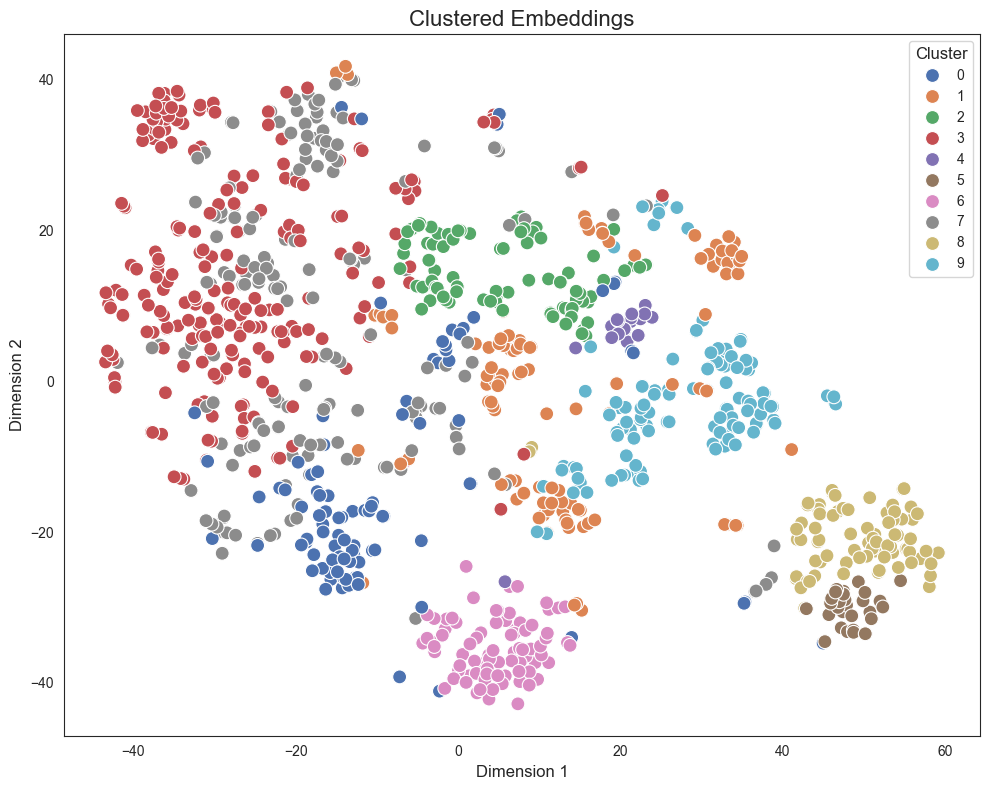

In [52]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Perform t-SNE to reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
reduced_data_tsne = tsne.fit_transform(np.array(vectors))

# Set Seaborn style for better aesthetics
sns.set_style("white")

# Plot the reduced data with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=reduced_data_tsne[:, 0],
    y=reduced_data_tsne[:, 1],
    hue=cluster_labels,
    palette="deep",
    s=100
)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.title("Clustered Embeddings", fontsize=16)
plt.legend(title="Cluster", title_fontsize=12)

# Set background color
plt.gcf().patch.set_facecolor("white")

plt.tight_layout()
plt.show()

Explanation:
- `TSNE` reduces the dimensionality of the document vectors for visualization purposes.
- Each point represents a document, colored by its cluster label.

**4. Select Representative Documents from Each Cluster**

- The document closest to the cluster centroid is selected as the representative document for that cluster.

In [53]:
# List to store the indices of the closest documents for each cluster
closest_indices = []

# Identify the closest document for each cluster
for i in range(num_clusters):
    distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)
    closest_index = np.argmin(distances)
    closest_indices.append(closest_index)

# Sort the indices for sequential processing
selected_indices = sorted(closest_indices)
selected_indices


[68, 171, 178, 402, 475, 513, 681, 739, 790, 810]

Explanation:
- For each cluster, the document closest to the cluster center is identified.
- The indices are sorted to ensure sequential summarization later.

**5. Convert Selected Documents to LangChain Document Format**

- The selected documents are converted to LangChain's `Document` format for compatibility with the summarization chain.

In [54]:
from langchain_core.documents import Document

# Convert the selected documents into LangChain's Document format
selected_docs = [Document(page_content=split_docs[doc]) for doc in selected_indices]
selected_docs

[Document(metadata={}, page_content='35\nArtificial Intelligence\nIndex Report 2024 Chapter 1 Preview Table of Contents75.48%\n14.06%\n5.60%\n4.87%75.63%\n9.47%\n9.28%\n5.62%81.75%\n10.05%7.39%\n0.80%\n0% 10% 20% 30% 40% 50% 60% 70% 80%Nonpr otGovernmentIndustryEducation\nUnited S tates\nEuropean U nion and U nited Kingdom\nChina\nAI public ations (% of t otal)AI p ublic ations (% of t otal) b y sector and geogr aphic ar ea, 20 22\nSource: Center for Security and E merging T echnolog y, 2023 | C hart: 202 4 AI Inde x repor t1.1 PublicationsChapter 1: Research and Development\nFigure 1.1.5Artificial Intelligence\nIndex Report 2024'),
 Document(metadata={}, page_content='91\nArtificial Intelligence\nIndex Report 2024 Chapter 2 Preview Table of ContentsChapter 2: Technical Performance Artificial Intelligence\nIndex Report 2024 2.2 Language\n2021 2022 20230.300.350.400.450.500.550.60MC1 ↑0.59Mult iple-choic e task on T ruthfulQA: MC1\nSource: Papers with C ode, 2023 | C hart: 202 4 AI Inde

**6. Generate the Final Summary Using the Map-Refine Chain**

* The **Map-Refine Chain** is used to generate a refined summary from the selected representative documents.

In [55]:
# Generate a refined summary using the Map-Refine Chain
refined_summary = map_refine_chain.invoke(selected_docs)

# Print the final refined summary
print("\n========== Final Refined Summary ==========\n")
print(refined_summary)

The document presents the "Artificial Intelligence Index Report 2024," focusing on the landscape of AI research and development.
It highlights the distribution of AI publications across various sectors and geographic areas, with notable contributions from the United States, European Union, United Kingdom, and China.
The report indicates that the majority of AI publications come from the non-profit sector, followed by government and industry.
It emphasizes the growing importance of AI in various fields, reflecting a significant increase in research output.
Additionally, the report discusses the technical performance of AI, particularly in language capabilities, showcasing trends in multiple-choice tasks on the TruthfulQA benchmark from 2021 to 2023.
The performance metric MC1 shows a gradual increase, indicating improvements in AI language understanding over the years.
The data is sourced from the Center for Security and Emerging Technology and "Papers with Code," underscoring the relev